In [75]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import networkx as nx
from tqdm import tqdm
from torch_geometric.utils import to_networkx

In [76]:
path = "../data/PAMAP2/raw_data/"

### Load PAMAP2 data

In [77]:
all_subject_data = []

columns_to_keep = (
        [0, 1, 2] +  # label
        list(range(4, 7)) + list(range(10, 16)) +  # IMU hand
        list(range(21, 24)) + list(range(27, 33)) +  # IMU chest
        list(range(38, 41)) + list(range(44, 50))  # IMU ankle
)

for file_i in tqdm(os.listdir(path)):
    subject_path = f"{path}/{file_i}"
    subject_data = pd.read_csv(subject_path, sep=' ', header=None)
    subject_data = subject_data.iloc[:, columns_to_keep]
    subject_data.drop(index=list(subject_data[subject_data.iloc[:, 1] == 0].index), inplace=True) 
    subject_data.reset_index(drop=True, inplace=True)
    
    # if fillnan == "interpolate":
    subject_data.interpolate(method="linear", axis=0, inplace=True)
    # elif fillnan == "zero":
    #     logging.info("Filling missing values, zeros.")
    #     subject_data.fillna(0, inplace=True)
    # elif fillnan == "dropna":
    #     logging.info("Deleting rows with NaN values")
    #     subject_data.dropna(axis=0, inplace=True)

    subject_data["user"] = int(file_i.split(".")[0][-3:])
    all_subject_data.append(subject_data)

all_subject_data = pd.concat(all_subject_data, axis=0)
all_subject_data.reset_index(drop=True, inplace=True)

# remove the transition data, label=0
all_subject_data.drop(index=list(all_subject_data[all_subject_data.iloc[:, 1] == 0].index), inplace=True)
all_subject_data.reset_index(drop=True, inplace=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.70s/it]


In [78]:
all_subject_data.columns = [
    'timestamp', 'label', 'heart_rate',
    'hand_Acc_X', 'hand_Acc_Y', 'hand_Acc_Z',
    # 'hand_Acc2_X', 'hand_Acc2_Y', 'hand_Acc2_Z',
    'hand_Gyr_X', 'hand_Gyr_Y', 'hand_Gyr_Z',
    'hand_Mag_X', 'hand_Mag_Y', 'hand_Mag_Z',
    'chest_Acc_X', 'chest_Acc_Y', 'chest_Acc_Z',
    # 'chest_Acc2_X', 'chest_Acc2_Y', 'chest_Acc2_Z',
    'chest_Gyr_X', 'chest_Gyr_Y', 'chest_Gyr_Z',
    'chest_Mag_X', 'chest_Mag_Y', 'chest_Mag_Z',
    'ank_Acc_X', 'ank_Acc_Y', 'ank_Acc_Z',
    # 'ank_Acc2_X', 'ank_Acc2_Y', 'ank_Acc2_Z',
    'ank_Gyr_X', 'ank_Gyr_Y', 'ank_Gyr_Z',
    'ank_Mag_X', 'ank_Mag_Y', 'ank_Mag_Z',
    'user'
]

In [79]:
activity_labels = {v: k for k, v in enumerate(np.unique(all_subject_data.label))}
activity_mapping = {k: v for k, v in enumerate(
            ['Lying down', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordic Walk', 'Walking Upstairs',
             'Walking Downstairs', 'Vacuum Cleaning', 'Ironing', 'Rope Jumping'])}
all_subject_data.head()

,timestamp,label,heart_rate,hand_Acc_X,hand_Acc_Y,hand_Acc_Z,hand_Gyr_X,hand_Gyr_Y,hand_Gyr_Z,hand_Mag_X,...,ank_Acc_X,ank_Acc_Y,ank_Acc_Z,ank_Gyr_X,ank_Gyr_Y,ank_Gyr_Z,ank_Mag_X,ank_Mag_Y,ank_Mag_Z,user
0,67.36,1,84.0,-9.64938,-1.68584,0.978888,-0.008240,-0.029004,0.002536,48.5864,...,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427,-34.9285,37.8429,-17.4803,108
1,67.37,1,84.0,-9.80348,-1.72328,0.899731,0.054293,-0.001861,-0.023345,48.8379,...,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885,-34.9496,38.6152,-17.9068,108
2,67.38,1,84.0,-9.65232,-1.53509,0.862873,0.000324,-0.042501,-0.037061,49.4642,...,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795,-35.5699,37.4857,-18.4750,108
3,67.39,1,84.0,-9.65045,-1.64823,0.940257,0.009701,-0.012660,0.007476,48.4682,...,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015,-35.4679,38.7685,-18.3343,108
4,67.40,1,84.0,-9.54564,-1.53764,0.672043,-0.026993,-0.003300,0.006464,48.5976,...,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670,-35.4625,38.5107,-18.3340,108


In [80]:
all_subject_data2 = []

columns_to_keep = (
        [0, 1, 2] +  # label
        list(range(4, 7)) + list(range(10, 16)) +  # IMU hand
        list(range(21, 24)) + list(range(27, 33)) +  # IMU chest
        list(range(38, 41)) + list(range(44, 50))  # IMU ankle
)

for file_i in tqdm(os.listdir(path)):
    subject_path = f"{path}/{file_i}"
    subject_data = pd.read_csv(subject_path, sep=' ', header=None)
    subject_data = subject_data.iloc[:, columns_to_keep]
    subject_data.drop(index=list(subject_data[subject_data.iloc[:, 1] == 0].index), inplace=True) 
    subject_data.reset_index(drop=True, inplace=True)
    
    # if fillnan == "interpolate":
    subject_data.interpolate(method="polynomial", order=5, axis=0, inplace=True)
    # elif fillnan == "zero":
    #     logging.info("Filling missing values, zeros.")
    #     subject_data.fillna(0, inplace=True)
    # elif fillnan == "dropna":
    #     logging.info("Deleting rows with NaN values")
    #     subject_data.dropna(axis=0, inplace=True)

    subject_data["user"] = int(file_i.split(".")[0][-3:])
    all_subject_data2.append(subject_data)

all_subject_data2 = pd.concat(all_subject_data2, axis=0)
all_subject_data2.reset_index(drop=True, inplace=True)

# remove the transition data, label=0
all_subject_data2.drop(index=list(all_subject_data2[all_subject_data2.iloc[:, 1] == 0].index), inplace=True)
all_subject_data2.reset_index(drop=True, inplace=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:24<00:00,  2.75s/it]


In [81]:
all_subject_data2.columns = [
    'timestamp', 'label', 'heart_rate',
    'hand_Acc_X', 'hand_Acc_Y', 'hand_Acc_Z',
    # 'hand_Acc2_X', 'hand_Acc2_Y', 'hand_Acc2_Z',
    'hand_Gyr_X', 'hand_Gyr_Y', 'hand_Gyr_Z',
    'hand_Mag_X', 'hand_Mag_Y', 'hand_Mag_Z',
    'chest_Acc_X', 'chest_Acc_Y', 'chest_Acc_Z',
    # 'chest_Acc2_X', 'chest_Acc2_Y', 'chest_Acc2_Z',
    'chest_Gyr_X', 'chest_Gyr_Y', 'chest_Gyr_Z',
    'chest_Mag_X', 'chest_Mag_Y', 'chest_Mag_Z',
    'ank_Acc_X', 'ank_Acc_Y', 'ank_Acc_Z',
    # 'ank_Acc2_X', 'ank_Acc2_Y', 'ank_Acc2_Z',
    'ank_Gyr_X', 'ank_Gyr_Y', 'ank_Gyr_Z',
    'ank_Mag_X', 'ank_Mag_Y', 'ank_Mag_Z',
    'user'
]

In [82]:
activity_labels = {v: k for k, v in enumerate(np.unique(all_subject_data2.label))}
activity_mapping = {k: v for k, v in enumerate(
            ['Lying down', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordic Walk', 'Walking Upstairs',
             'Walking Downstairs', 'Vacuum Cleaning', 'Ironing', 'Rope Jumping'])}
all_subject_data2.head()

,timestamp,label,heart_rate,hand_Acc_X,hand_Acc_Y,hand_Acc_Z,hand_Gyr_X,hand_Gyr_Y,hand_Gyr_Z,hand_Mag_X,...,ank_Acc_X,ank_Acc_Y,ank_Acc_Z,ank_Gyr_X,ank_Gyr_Y,ank_Gyr_Z,ank_Mag_X,ank_Mag_Y,ank_Mag_Z,user
0,67.36,1,84.000000,-9.64938,-1.68584,0.978888,-0.008240,-0.029004,0.002536,48.5864,...,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427,-34.9285,37.8429,-17.4803,108
1,67.37,1,83.999998,-9.80348,-1.72328,0.899731,0.054293,-0.001861,-0.023345,48.8379,...,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885,-34.9496,38.6152,-17.9068,108
2,67.38,1,83.999997,-9.65232,-1.53509,0.862873,0.000324,-0.042501,-0.037061,49.4642,...,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795,-35.5699,37.4857,-18.4750,108
3,67.39,1,83.999997,-9.65045,-1.64823,0.940257,0.009701,-0.012660,0.007476,48.4682,...,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015,-35.4679,38.7685,-18.3343,108
4,67.40,1,83.999997,-9.54564,-1.53764,0.672043,-0.026993,-0.003300,0.006464,48.5976,...,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670,-35.4625,38.5107,-18.3340,108


In [150]:
data1 = np.random.randn(100)
idx = np.random.choice(range(100), 30, replace=False)
data1[idx] = np.nan
data2 = data1.copy()

df = pd.DataFrame(data=np.hstack((data1.reshape(-1, 1), data2.reshape(-1, 1))), columns=['a', 'b'])
df2 = df.copy()
df3 = df.copy()

df.interpolate(method="polynomial", order=5, axis=0, inplace=True)
df2.interpolate(method="linear", axis=0, inplace=True)

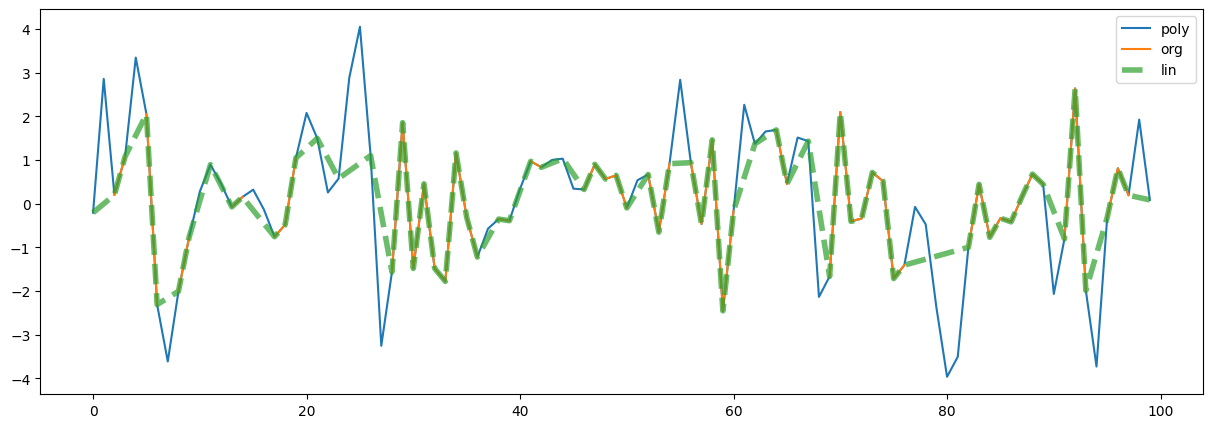

In [161]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df.a)), df.a, alpha=1, label='poly')
plt.plot(range(len(df3.a)), df3.a, alpha=1, label='org')
plt.plot(range(len(df2.a)), df2.a, '--', alpha=0.7, linewidth=4, label='lin')
plt.legend()
plt.show()

In [35]:
clean_data = all_subjec.t_data.interpolate(method="polynomial", order=5, axis=0)
clean_data.iloc[-1, 2] = 162

In [58]:
val_subjects = [101, 107]
test_subjects = [103, 105]
train_subjects = [102, 104, 106, 108, 109]

train_mask = np.in1d(all_subject_data.user, train_subjects)
val_mask = np.in1d(all_subject_data.user, val_subjects)
test_mask = np.in1d(all_subject_data.user, test_subjects)

X_train = all_subject_data.iloc[train_mask, 2:-1]
y_train = all_subject_data.iloc[train_mask, 1]

X_val = all_subject_data.iloc[val_mask, 2:-1]
y_val = all_subject_data.iloc[val_mask, 1]

X_test = all_subject_data.iloc[test_mask, 2:-1]
y_test = all_subject_data.iloc[test_mask, 1]

In [59]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
   
    print("Accuracy: ",acc)
    print("Error: ",acc)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)
    #print("Accuracy: %.3f \nError: %.3f \nPrecesion: %.3f \nRecall: %.3f \nF1:%.3f \n"% (acc,err,p,r,f1) )

In [60]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs =4)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
get_metrics(y_test,y_pred_rf)

KeyboardInterrupt: 

In [37]:
train_data.head()

,timestamp,label,heart_rate,hand_Acc_X,hand_Acc_Y,hand_Acc_Z,hand_Gyr_X,hand_Gyr_Y,hand_Gyr_Z,hand_Mag_X,...,ank_Acc_X,ank_Acc_Y,ank_Acc_Z,ank_Gyr_X,ank_Gyr_Y,ank_Gyr_Z,ank_Mag_X,ank_Mag_Y,ank_Mag_Z,user
0,67.36,1,84.000000,-9.64938,-1.68584,0.978888,-0.008240,-0.029004,0.002536,48.5864,...,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427,-34.9285,37.8429,-17.4803,108
1,67.37,1,83.999998,-9.80348,-1.72328,0.899731,0.054293,-0.001861,-0.023345,48.8379,...,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885,-34.9496,38.6152,-17.9068,108
2,67.38,1,83.999997,-9.65232,-1.53509,0.862873,0.000324,-0.042501,-0.037061,49.4642,...,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795,-35.5699,37.4857,-18.4750,108
3,67.39,1,83.999997,-9.65045,-1.64823,0.940257,0.009701,-0.012660,0.007476,48.4682,...,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015,-35.4679,38.7685,-18.3343,108
4,67.40,1,83.999997,-9.54564,-1.53764,0.672043,-0.026993,-0.003300,0.006464,48.5976,...,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670,-35.4625,38.5107,-18.3340,108


In [62]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_scaled = (X_train - mean) / std

In [38]:
npdata = np.asarray(train_data.iloc[:,2:-1])
corr = np.corrcoef(npdata.T)
# corr[np.abs(corr)<=0.2] = 0
# corr[np.abs(corr)>=0.98] = 0 

corr = np.abs(corr) / np.abs(corr.max())

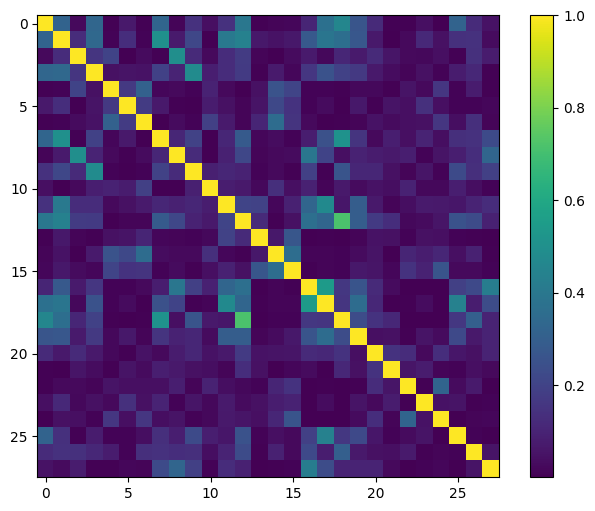

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr, cmap=plt.cm.viridis)
fig.colorbar(im, orientation='vertical')
plt.show()

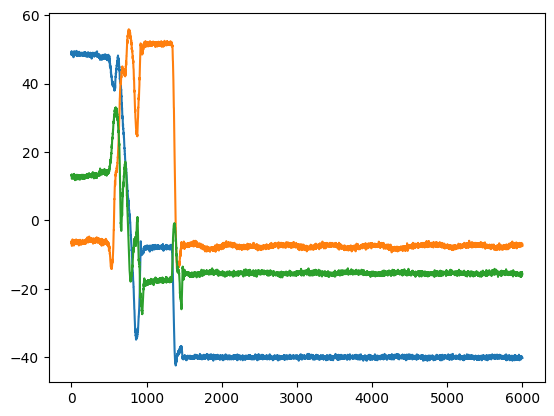

In [72]:
data = all_subject_data.iloc[0:6000, 9:12].values.copy()
# data2 = clean_data.loc[:,"hand_Acc_X"].values.copy()
# data[np.where(np.isnan(data))[0]] = 25
plt.plot(range(len(data)), data)
plt.show()

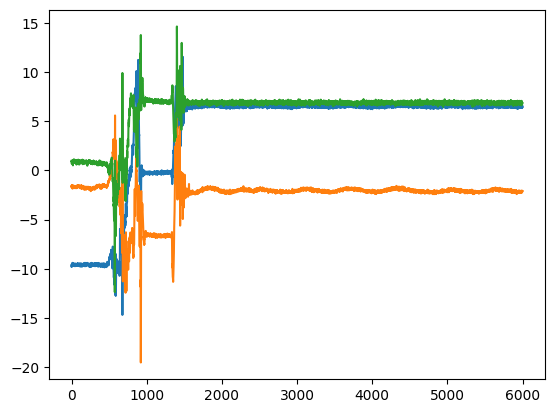

In [73]:
data = clean_data.iloc[0:6000,3:6].values.copy()
# data2 = clean_data.loc[:,"hand_Acc_X"].values.copy()
# data[np.where(np.isnan(data))[0]] = 25
plt.plot(range(len(data)), data)
plt.show()

In [ ]:
np.where(np.isnan(data))[0][5000:6000]

In [ ]:
len(data)

In [ ]:
n1=993000
n2=994000

print(n2-n1)

plt.figure(figsize=(20,10))
plt.plot(range(len(data[n1:n2])), data[n1:n2], linewidth=2, color='blue', label='raw')
plt.plot(range(len(data2[n1:n2])), data2[n1:n2], linewidth=2, color='green', label='NaN values', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
nan_idx

In [ ]:
len(data)

In [ ]:
nan_idx = np.where(np.isnan(data))[0]
nan_idx
# nan_idx[(nan_idx>1000) & (nan_idx<3000)]

In [ ]:
activity_labels

In [ ]:
activity_mapping

In [ ]:
all_subject_data["num_nan"] = all_subject_data.isnull().any(axis=1).values.astype(int)

In [ ]:
all_subject_data.loc[:,["label", "user", "num_nan"]].groupby(['user','label']).sum()

In [ ]:
nulls_distribution["activity"] = [activity_mapping[activity_labels[l]] for l in nulls_distribution.index.get_level_values('label')]

In [ ]:
nulls_distribution[nulls_distribution.index.get_level_values('user') == 101].sort_values(by="num_nan", ascending=False)

In [ ]:
nulls_distribution[nulls_distribution.index.get_level_values('user') == 107].sort_values(by="num_nan", ascending=False)

In [ ]:
nan_per_activity = nulls_distribution.loc[:,["activity", "num_nan"]].groupby('activity').sum()
nan_per_activity.sort_values(by=["num_nan"], ascending=False)

In [ ]:
num_activities = all_subject_data.loc[:,["label", "num_nan"]].groupby('label').count()
num_activities.sort_values(by=["num_nan"], ascending=False)

In [ ]:
nulls_distribution[nulls_distribution.index.get_level_values('user') == 103].sort_values(by="num_nan", ascending=False)

In [ ]:
nulls_distribution[nulls_distribution.index.get_level_values('user') == 105].sort_values(by="num_nan", ascending=False)

In [ ]:
nan_per_user = all_subject_data.loc[:,["user", "num_nan"]].groupby(['user']).sum()
nan_per_user.sort_values(by=["num_nan"], ascending=False)

In [ ]:
ax = nulls_distribution.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(12, 6), layout=(4, 3))
plt.tight_layout()